# Hashing analysis
## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from dbspro.notebook import *
from datetime import date

sns.set_context("notebook", font_scale=1.2)
sns.set_style("ticks")

In [2]:
%matplotlib inline

In [3]:
# Functions
def today():
    return date.today().strftime("%y%m%d")

print(today())

220516


## Load data

In [4]:
# Load metadata
abc_target = pd.read_csv("../data/hashing.abc_target.csv", names=["abc", "target"]).set_index("abc").to_dict()["target"]
targets = list(abc_target.values())

sample_names= pd.read_csv("../data/hashing.samples.tsv", dtype=str, sep="\t")
print(sample_names["Sample"].to_list())


['Hash1_4xA', 'Pash1_4xA', 'Hash2_4xA', 'Hashing2_2x_B_C', 'Pashing2_2x_D_E']


In [5]:
rename_samples = {
    'Hash1_4xA': "EV_hashing_1", 
    'Pash1_4xA': "Bead_hashing_1", 
    'Hash2_4xA': "EV_hashing_2", 
    'Hashing2_2x_B_C': "EV_hashing_3", 
    'Pashing2_2x_D_E': "Bead_hashing_2"
}
sample_names["OldName"] = sample_names["Sample"]
sample_names.replace({"Sample": rename_samples}, inplace=True)
samples = sorted(sample_names["Sample"].to_list())
display(samples)
display(sample_names)

['Bead_hashing_1',
 'Bead_hashing_2',
 'EV_hashing_1',
 'EV_hashing_2',
 'EV_hashing_3']

,Sample,Reads,FastqPath,OldName
0,EV_hashing_1,1407684,/Users/pontus.hojer/analysis/DBS-Pro_Exosomes/...,Hash1_4xA
1,Bead_hashing_1,1690871,/Users/pontus.hojer/analysis/DBS-Pro_Exosomes/...,Pash1_4xA
2,EV_hashing_2,1810909,/Users/pontus.hojer/analysis/DBS-Pro_Exosomes/...,Hash2_4xA
3,EV_hashing_3,1560185,/Users/pontus.hojer/analysis/DBS-Pro_Exosomes/...,Hashing2_2x_B_C
4,Bead_hashing_2,2239036,/Users/pontus.hojer/analysis/DBS-Pro_Exosomes/...,Pashing2_2x_D_E


In [6]:
# Load data
data_raw = pd.read_csv("../data/hashing.tsv.gz", sep="\t")

# Rename ABCs to targets and update sample names
data_raw.replace({"Target": abc_target, "Sample": rename_samples}, inplace=True)

# Filter out UMIs with only one read count
print("Size before:", len(data_raw))
data_raw = data_raw[data_raw["ReadCount"] > 1]
print("Size after:", len(data_raw))

Size before: 1979386
Size after: 661999


## Overall QC

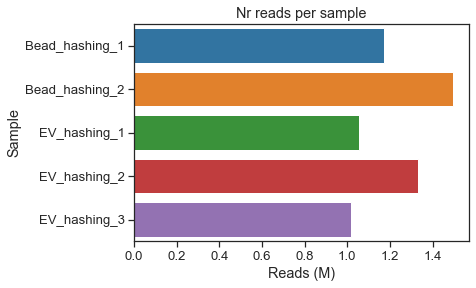

In [7]:
d = data_raw.groupby("Sample", as_index=False).sum()
d["ReadCount"] /= 1_000_000
ax = sns.barplot(data=d, y="Sample", x="ReadCount", order=samples)
_ = ax.set_xlabel("Reads (M)")
_ = ax.set_title("Nr reads per sample")

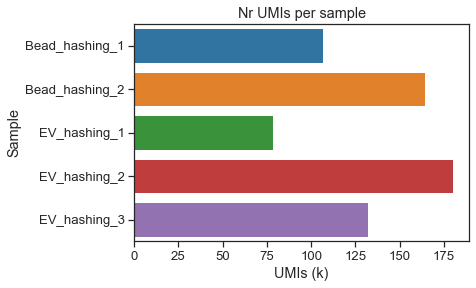

In [8]:
d = data_raw.groupby("Sample", as_index=False).count()
d["UMI"] /= 1_000
ax = sns.barplot(data=d, y="Sample", x="UMI", order=samples)
_ = ax.set_xlabel("UMIs (k)")
_ = ax.set_title("Nr UMIs per sample")

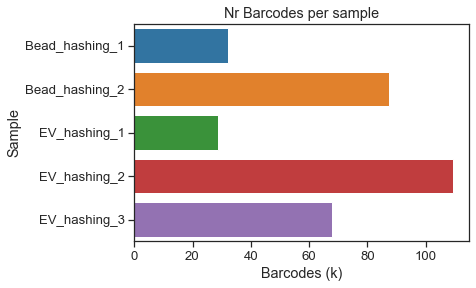

In [9]:
d = data_raw.groupby("Sample").agg({"Barcode":"nunique"})
d /= 1_000

ax = sns.barplot(data=d, y=d.index, x="Barcode", order=samples)
_ = ax.set_xlabel("Barcodes (k)")
_ = ax.set_title("Nr Barcodes per sample")

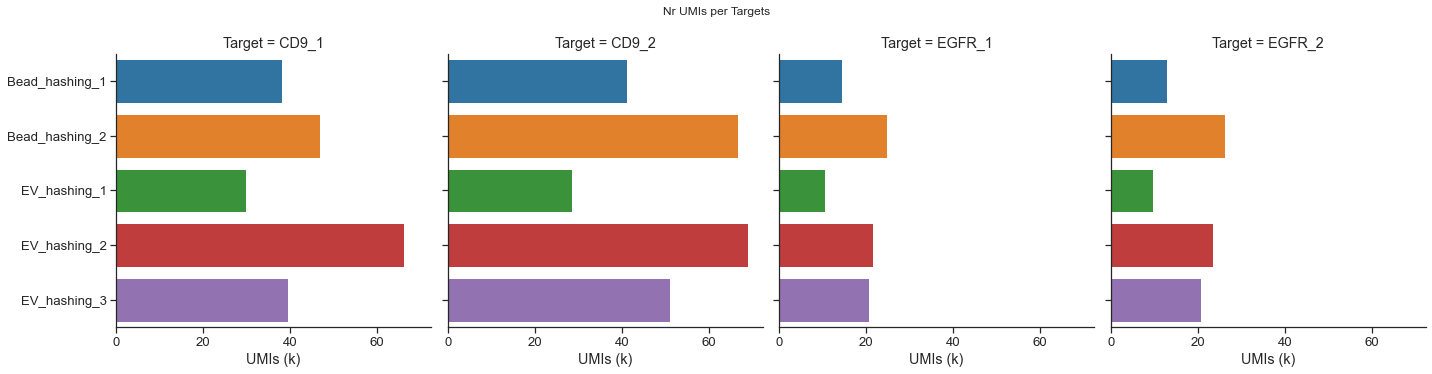

In [10]:
d = data_raw.groupby(["Sample", "Target"], as_index=False).agg({"UMI":"count"})
d["UMI"] /= 1000
g = sns.catplot(data=d, y="Sample", x="UMI",  col="Target", col_wrap=4, kind="bar")
g.fig.subplots_adjust(top=0.85)
_ = g.fig.suptitle("Nr UMIs per Targets")
_ = g.set_axis_labels("UMIs (k)", "")

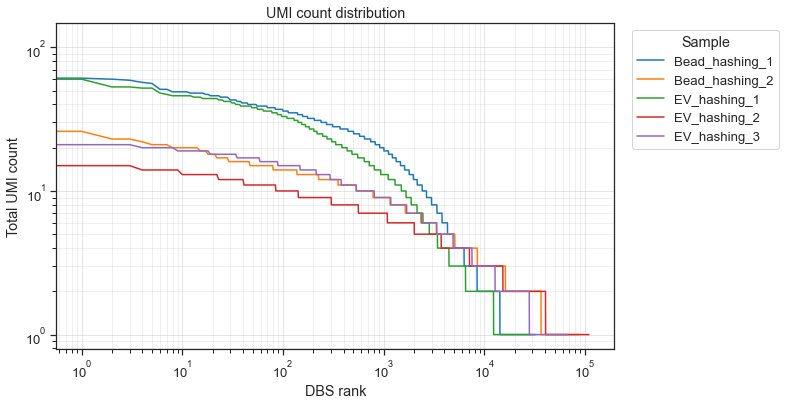

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("UMI count distribution")
for sample in samples:
    temp = data_raw[data_raw["Sample"] == sample].groupby("Barcode", as_index=False)["UMI"].count().sort_values(by="UMI",ascending=False).reset_index(drop=True)
    temp.plot(ax=ax, y="UMI", logx=True, logy=True, label=sample)
    
ax.set_xlabel("DBS rank")
ax.set_ylabel("Total UMI count")
#ax.set_xlim(0,100_000)
ax.grid('on', which='major', axis='y', alpha=0.5 )
ax.grid('on', which='major', axis='x',alpha=0.5)
ax.grid('on', which='minor', axis='y', alpha=0.3)
ax.grid('on', which='minor', axis='x', alpha=0.3)
_ = plt.legend(bbox_to_anchor=(1.02, 1), title="Sample", loc='upper left')

(-5.0, 100.0)

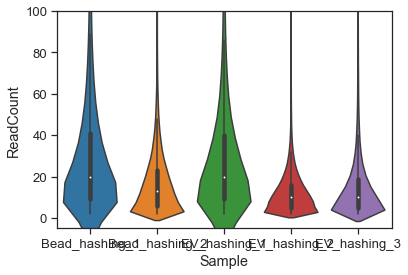

In [12]:
ax = sns.violinplot(data=data_raw.groupby(["Sample","Barcode"], as_index=False)["ReadCount"].sum(), kind="violin", x="Sample", y="ReadCount", bw_adjust=0.1, scale="width")
ax.set_ylim(-5,100)

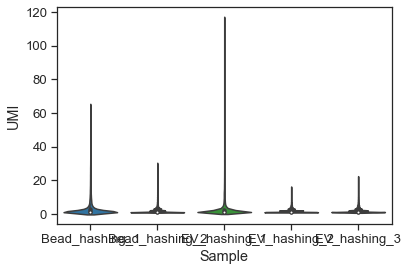

In [13]:
ax = sns.violinplot(data=data_raw.groupby(["Sample","Barcode"], as_index=False)["UMI"].count(), 
                    x="Sample", y="UMI", bw_adjust=0.1, scale="width")


## Filter and generate counts matrix

In [14]:
data_count = []
for s in tqdm(samples):
    print(s)
    data_count.append(
        data_raw[data_raw["Sample"]==s]\
            .filter_rc(1)\
            .filter_uc(1)\
            .filter_ratio(3)\
            .filter_target_count(1)
            .filter_dups(0.5, min_len=2)\
            .to_matrix(qc=True).assign(Sample=s)
    )
    print("")
data_count = pd.concat(data_count)

  0%|          | 0/5 [00:00<?, ?it/s]

Bead_hashing_1
Filtering molecules per readcount gt 1
Barcodes = 32,287 (-0, -0.0%, runtime:0.01247096061706543 s)
Filtering barcodes by total UMI count gt 1
Barcodes = 14,251 (-18,036, -55.86%, runtime:0.03130507469177246 s)
Filtering barcodes by Reads/UMI ratio gt 3
Barcodes = 8,538 (-5,713, -40.09%, runtime:0.030642032623291016 s)
Filtering for targets with UMI count gt 1
Barcodes = 7,786 (-752, -8.81%, runtime:0.015022754669189453 s)
Filter barcodes whose UMI + Target combos have a jaccard index >0.5
Barcodes = 5,270 (-2,516, -32.31%, runtime:1.589167833328247 s)

Bead_hashing_2
Filtering molecules per readcount gt 1
Barcodes = 87,419 (-0, -0.0%, runtime:0.0231781005859375 s)
Filtering barcodes by total UMI count gt 1
Barcodes = 36,536 (-50,883, -58.21%, runtime:0.06568694114685059 s)
Filtering barcodes by Reads/UMI ratio gt 3
Barcodes = 24,835 (-11,701, -32.03%, runtime:0.06336593627929688 s)
Filtering for targets with UMI count gt 1
Barcodes = 22,306 (-2,529, -10.18%, runtime:0.0

In [15]:
# Save counts to simply rerunning analysis from here.
data_count.to_csv("../data/hashing.counts.tsv.gz", sep="\t")

# Comment out the row above and run the code below if rerunning analysis
#data_count = pd.read_csv("../data/hashing.counts.tsv.gz", sep="\t").set_index("Barcode")

## Per Droplet QC

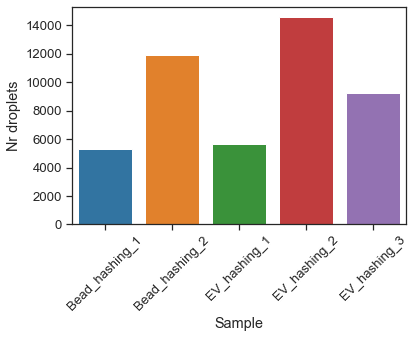

In [16]:
ax = sns.barplot(data=data_count.groupby("Sample", as_index=False).count(), x="Sample", y="total_count")
ax.set_ylabel("Nr droplets")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

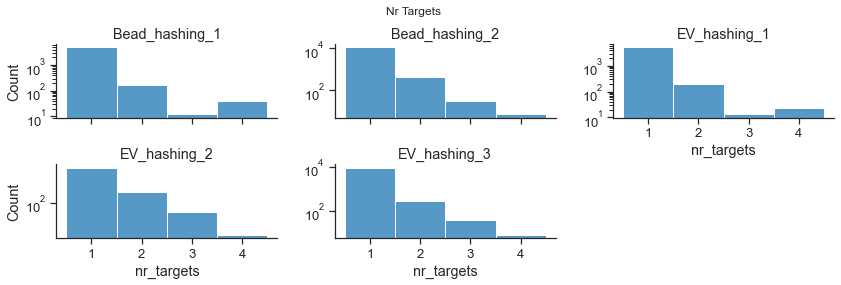

In [17]:
bins = np.array(range(1,6))

g = sns.displot(data_count, x="nr_targets", col="Sample", col_wrap=3, bins=bins, 
                height=2, aspect=2, facet_kws={'sharey': False})
g.fig.subplots_adjust(top=0.85)
_ = g.fig.suptitle("Nr Targets")
g.set(yscale="log", xticks = bins[:-1] + 0.5, xticklabels=bins[:-1])
g.set_titles("{col_name}")

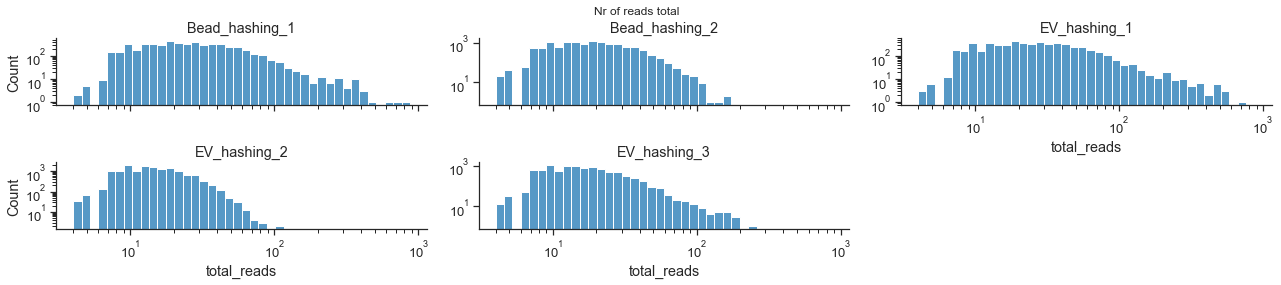

In [18]:
d = data_count.copy()
g = sns.displot(d, x="total_reads", col="Sample", log_scale=True, col_wrap=3, bins=40,
                height=2, aspect=3, facet_kws={'sharey': False})
g.fig.subplots_adjust(top=0.87)
_ = g.fig.suptitle("Nr of reads total")
g.set(yscale="log", )
g.set_titles("{col_name}")

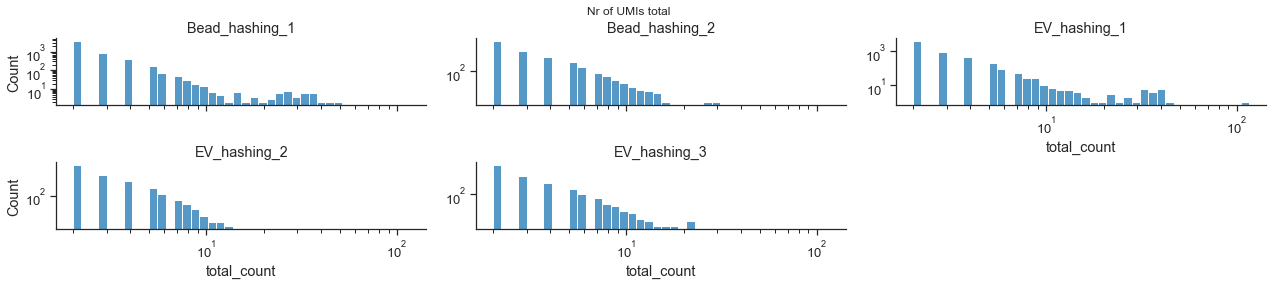

In [19]:
d = data_count.copy()
g = sns.displot(d, x="total_count", col="Sample", log_scale=True, col_wrap=3, bins=40,
                height=2, aspect=3, facet_kws={'sharey': False})
g.fig.subplots_adjust(top=0.87)
_ = g.fig.suptitle("Nr of UMIs total")
g.set(yscale="log", )
g.set_titles("{col_name}")

## Mixing analysis

In [20]:
d = data_count.copy()
threshold = 0.95

# Classify droplets
d["Set1"] = d["CD9_1"] + d["EGFR_1"]
d["Set2"] = d["CD9_2"] + d["EGFR_2"]
d["OnlySet1"] = ((d["Set1"] / d["total_count"]) > threshold).astype(int)
d["OnlySet2"] = ((d["Set2"] / d["total_count"]) > threshold).astype(int)
d["BothSets"] = ((d["OnlySet1"]==0) & (d["OnlySet2"]==0)).astype(int)
d["AnySet"]  = 1

# Aggregate number of droplet of each typ for each sample
d_mix = d.groupby("Sample")[["OnlySet1", "OnlySet2", "BothSets", "AnySet"]].sum()

# Calculate percent mixed and single
d_mix["Mixed"] = 100 * d_mix["BothSets"] / d_mix["AnySet"] 
d_mix["SingleSet"] = 100 - d_mix["Mixed"]
display(d_mix)

Target,OnlySet1,OnlySet2,BothSets,AnySet,Mixed,SingleSet
Sample,,,,,,
Bead_hashing_1,2537,2627,106,5270,2.011385,97.988615
Bead_hashing_2,4764,6986,178,11928,1.492287,98.507713
EV_hashing_1,2656,2868,99,5623,1.760626,98.239374
EV_hashing_2,6459,7916,182,14557,1.250258,98.749742
EV_hashing_3,3938,5167,127,9232,1.375650,98.624350


### Code for Figure 2B

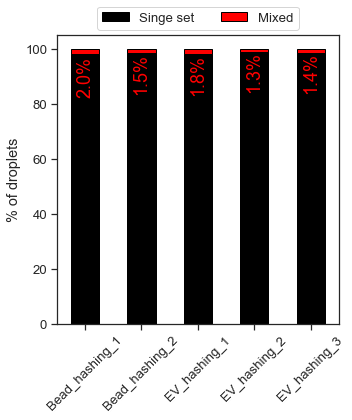

In [21]:
fig, ax = plt.subplots(figsize=(5,6))
ax = d_mix[["SingleSet", "Mixed"]].plot(kind="bar", stacked=True, edgecolor="black", color=["black", "red"], ax=ax)
ax.set_ylabel("% of droplets")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

_ = plt.legend(["Singe set", "Mixed"], ncol=2, bbox_to_anchor=(.5, 1.12), title=None, loc='upper center')


for bar, mix  in zip(ax.patches, d_mix["Mixed"]):
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    ax.annotate(f"{mix:.1f}%",
                (bar.get_x() + bar.get_width() / 2, bar.get_height() - mix - 9) , 
                ha='center', va='center', color="red",
                size=18, xytext=(0, 8), rotation=90,
                textcoords='offset points')
ax.set_xlabel("")
plt.tight_layout()

for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}.Hashing.mixing_rates_bars.{ext}", dpi=300)

### Code for Figure 2C

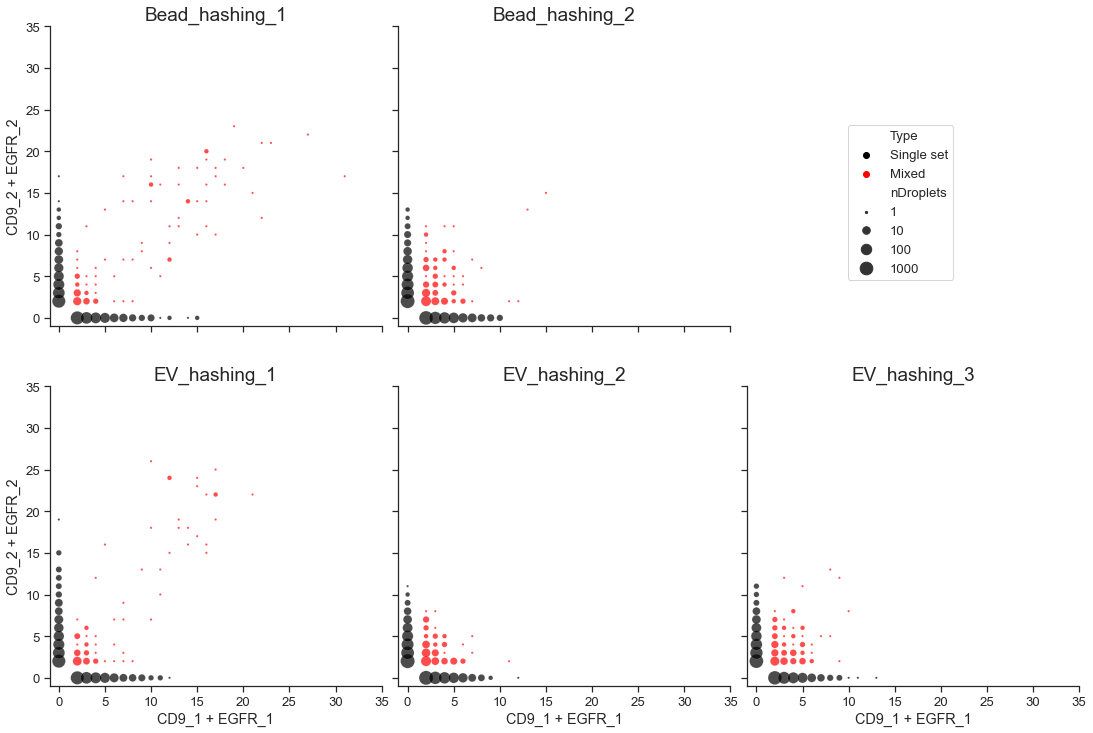

In [22]:
from matplotlib.colors import LogNorm

# From https://github.com/mwaskom/seaborn/issues/2280
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.fig.legend(handles, labels, loc=new_loc, title=title, **kws)
    old_legend.remove()

s = d.groupby(["Sample", "Set1", "Set2"], as_index=False)[["BothSets", "AnySet", "total_count"]].sum()
s["nDroplets"] = s["AnySet"]
s["log10(nDroplets)"] = np.log10(s["nDroplets"]).round(1)
s["mixed"] = s["BothSets"] > 0
s["Type"] = s["mixed"].apply(lambda x: "Mixed" if x else "Single set")

mix_rates = s.groupby(["Sample"])[["BothSets", "AnySet"]].sum()
mix_rates["Mixed"] = 100 * mix_rates["BothSets"] / mix_rates["AnySet"] 

lims=(-1,35)
rename_row = {sample: sample.split("_")[0] for sample in set(d["Sample"])}
rename_col = {sample: sample.split("_")[-1] for sample in set(d["Sample"])}
s["Experiment"] = s["Sample"].replace(rename_row)
s["Batch"] = s["Sample"].replace(rename_col)

g = sns.relplot(data=s, x="Set1", y="Set2", size="nDroplets", size_norm=LogNorm(),
                hue="Type", col="Batch", row="Experiment", sizes=(5,200),
                palette=["black", "red"], alpha=0.7)
g.fig.subplots_adjust(hspace=0.2)
_ = g.set(xlabel="CD9_1 + EGFR_1", ylabel="CD9_2 + EGFR_2", ylim=lims, xlim=lims)
_ = g.set_titles('{row_name}_hashing_{col_name}', size=19)
move_legend(g, "lower center", bbox_to_anchor=(.75, .6))
g.fig.delaxes(g.axes_dict[("Bead", "3")])

for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}.Hashing.mixing_rates_dotplot.{ext}", dpi=300, bbox_inches='tight')